## **Transforming Vertical Coordinates**

### **Description**

Recipe showing how to conservatively transform the vertical coordinate system on which a variable is stored using annual-mean outputs from the National Oceanography Centre Near-Present-Day global eORCA1 configuration of NEMO forced using ERA-5 climatologically adjusted atmospheric forcing from 1976-2024.

For more details on this model configuration and the available outputs, users can explore the Near-Present-Day documentation [here](https://noc-msm.github.io/NOC_Near_Present_Day/).

In [ ]:
# -- Import Python packages -- #
import glob
import numpy as np
import xarray as xr

# -- Import nemo_cookbook tools -- #
from nemo_cookbook import transform_vertical_coords

### **Preparing NEMO Model Data**
**Let's begin by defining the path to our annual-mean tracer (conservative temperature & absolute salinity) outputs.**

In [2]:
# Define directory path to model data:
data_dir = "/dssgfs01/scratch/npd/simulations/eORCA1_ERA5_v1"
# Define list of file names for NEMO T-grid:
fpaths_gridT = sorted(glob.glob(f"{data_dir}/eORCA1_ERA5_1y_grid_T_*.nc"))

### **Exploring our model vertical coordinate system**

Let's begin by visualising the conservative temperature in the original vertical coordinates of our eORCA1 NPD simulation by plotting a vertical profile.


In [3]:
# Open eORCA1 conservative temperature output data, rechunking along vertical coordinate dimension:
ds_gridT = xr.open_mfdataset(fpaths_gridT,
                             preprocess=lambda ds: ds[['thetao_con', 'e3t']],
                             chunks={'deptht':75},
                             )

# Rename our vertical coordinate from 'deptht' to 'z':
ds_gridT = ds_gridT.rename({'deptht': 'z'})

ds_gridT

<xarray.Dataset> Size: 4GB
Dimensions:        (time_counter: 49, z: 75, y: 331, x: 360)
Coordinates:
    nav_lat        (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    nav_lon        (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
  * z              (z) float32 300B 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  (time_counter) datetime64[ns] 392B dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 392B 1976-07-02 ... 2024-07-02
Dimensions without coordinates: y, x
Data variables:
    thetao_con     (time_counter, z, y, x) float32 2GB dask.array<chunksize=(1, 75, 67, 360), meta=np.ndarray>
    e3t            (time_counter, z, y, x) float32 2GB dask.array<chunksize=(1, 75, 67, 360), meta=np.ndarray>
Attributes:
    name:         OUTPUT/eORCA1_ERA5_1y_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2025-May-13 16:20:28 GMT
    uuid:         c71f9667-2744-4171-9d1a-1fb456679ff7

**By examining the vertical profile & the size of the `z` coordinate variable, we can see that our eORCA1 configuration has 75 unevenly-spaced z\*-coordinate levels.**

75

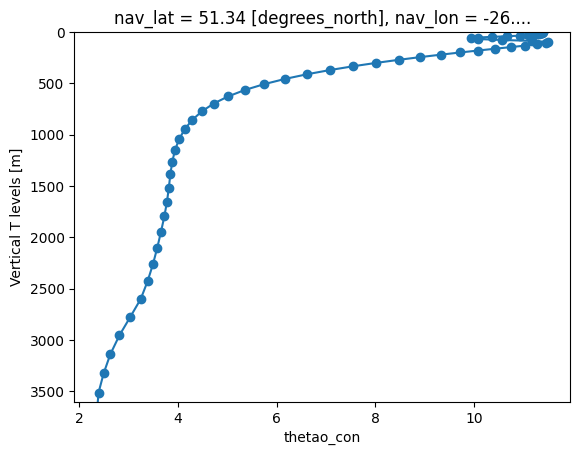

In [4]:
# Plot our example subpolar North Atlantic time-mean vertical profile:
ds_gridT['thetao_con'].isel(x=260, y=260).mean(dim='time_counter').plot(y='z', ylim=(3600, 0), marker='o')

# Size of the vertical coordinate:
ds_gridT.z.size

### **Transforming the vertical coordinate system**

**Next, let's apply a conservative vertical coordinate transformation to remap our conservative temperature output to a new regularly-spaced (200 m) vertical grid:**

In [5]:
# Define our target vertical grid coordinate:
e3t_target = xr.DataArray(np.repeat(200.0, 30), dims=['zt'])

e3t_target

<xarray.DataArray (zt: 30)> Size: 240B
array([200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200.])
Dimensions without coordinates: zt

In [ ]:
# Apply the vertical coordinate transformation to the entire time-series of conservative temperature:
thetao_con_out, e3t_out = transform_vertical_coords(var_in=ds_gridT['thetao_con'],
                                                    e3_in=ds_gridT['e3t'],
                                                    e3_target=e3t_target,
                                                    )

**Notice that the output above returns two dask arrays, so we haven't actually computed anything yet. To do this, we need to call the ``.compute()`` method:**

**The `e3t_out` variable includes partial grid cells at the sea floor.**

In [ ]:
thetao_con_out = thetao_con_out.compute()

### **Exploring our transformed model output**

**Let's plot our original and transformed vertical conservative temperature profile together.**

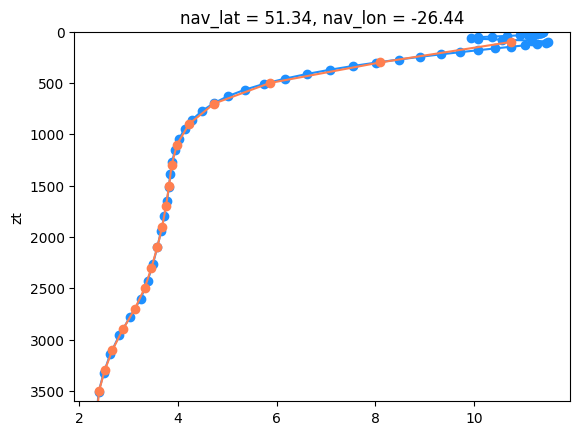

In [8]:
# Plot our original subpolar North Atlantic time-mean vertical profile:
ds_gridT['thetao_con'].isel(x=260, y=260).mean(dim='time_counter').plot(y='z', ylim=(3600, 0), marker='o', color='dodgerblue')

# Plot our transformed subpolar North Atlantic time-mean vertical profile:
thetao_con_out = thetao_con_out.assign_coords(zt=np.arange(100, 6000, 200))
thetao_con_out.isel(x=260, y=260).mean(dim='time_counter').plot(y='zt', ylim=(3600, 0), marker='o', color='coral')

**We can also verify that the product of the vertical grid cell thickness (m) and conservative temperature (C) is conserved following the transformation.**

In [9]:
# Calculate the sum of the product of the transformed conservative temperature and cell thickness at our example location:
print((thetao_con_out.isel(time_counter=0, x=260, y=260) * e3t_out.isel(time_counter=0, x=260, y=260)).sum().compute().round(3))

# Calculate the sum of the product of the original conservative temperature and cell thickness at our example location:
print((ds_gridT['thetao_con'].isel(time_counter=0, x=260, y=260) * ds_gridT['e3t'].isel(time_counter=0, x=260, y=260)).sum().compute().round(3))

<xarray.DataArray ()> Size: 8B
array(15514.528)
Coordinates:
    nav_lat        float32 4B 51.34
    nav_lon        float32 4B -26.44
    time_centered  datetime64[ns] 8B 1976-07-02
    time_counter   datetime64[ns] 8B 1976-07-02
<xarray.DataArray ()> Size: 4B
array(15514.528, dtype=float32)
Coordinates:
    nav_lat        float32 4B 51.34
    nav_lon        float32 4B -26.44
    time_centered  datetime64[ns] 8B 1976-07-02
    time_counter   datetime64[ns] 8B 1976-07-02
